In [202]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [203]:
import numpy as np
import pandas as pd
import datetime as dt
import statistics
from flask import Flask, jsonify

# Reflect Tables into SQLAlchemy ORM

In [204]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, inspect, func

In [205]:
# create engine to hawaii.sqlite
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [206]:
inspector = inspect(engine)
inspector.get_table_names()

['measurement', 'station']

In [207]:
m_columns = inspector.get_columns('measurement')
for c in m_columns:
    print(c['name'],c['type'])

id INTEGER
station TEXT
date TEXT
prcp FLOAT
tobs FLOAT


In [208]:
s_columns = inspector.get_columns('station')
for c in s_columns:
    print(c['name'],c['type'])

id INTEGER
station TEXT
name TEXT
latitude FLOAT
longitude FLOAT
elevation FLOAT


In [209]:
# reflect an existing database into a new model
Base = automap_base()

# reflect the tables
Base.prepare(engine, reflect=True)

In [210]:
# View all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [211]:
# Save references to each table
measurement = Base.classes.measurement
station = Base.classes.station

In [212]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Precipitation Analysis

In [213]:
# Find the most recent date in the data set.
session.query(measurement.date).order_by(measurement.date).first()

('2010-01-01',)

In [214]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results. 
# Starting from the most recent data point in the database. 
recent = session.query(measurement.date).order_by(measurement.date.desc()).first()
print(recent[0])

2017-08-23


In [215]:
# Calculate the date one year from the last date in data set.
one_year = '2016-08-23'
print(one_year)

2016-08-23


In [216]:
# Perform a query to retrieve the data and precipitation scores
engine.execute('SELECT * FROM measurement WHERE date BETWEEN "2016-08-23" AND "2017-08-23";').fetchall()
conn = engine.connect()
# Save the query results as a Pandas DataFrame and set the index to the date column
measurements_db = pd.read_sql('SELECT "date", "prcp" FROM measurement WHERE date BETWEEN "2016-08-23" AND "2017-08-23";', conn)
measurements_db.set_index('date')
# Sort the dataframe by date
measurements_db = measurements_db.sort_values(['date'], ascending=True)
measurements_db.head()

date  prcp
0     2016-08-23  0.00
1009  2016-08-23   NaN
1529  2016-08-23  1.79
704   2016-08-23  0.05
361   2016-08-23  0.15

In [217]:
# Use Pandas Plotting with Matplotlib to plot the data
grouped_measurements = measurements_db.groupby(['date'])
avg_prcp = grouped_measurements.mean()

(0.0, 2.0)

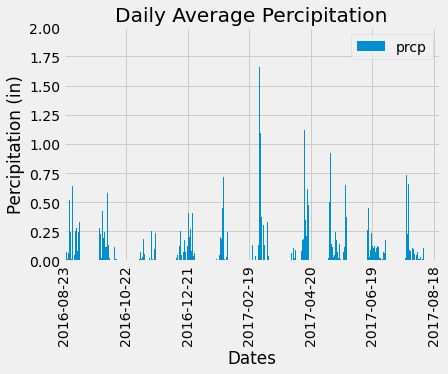

In [218]:
#plt.bar(avg_prcp[0], avg_prcp['prcp'], color='b', alpha=0.5, align='center')
avg_prcp.plot(kind='bar')
plt.xticks(np.arange(0, 366, 60))
plt.title('Daily Average Percipitation')
plt.xlabel('Dates')
plt.ylabel('Percipitation (in)')
plt.ylim(0,2)

In [219]:
# Use Pandas to calcualte the summary statistics for the precipitation data
mean_prcp = grouped_measurements.mean()
max_prcp = grouped_measurements.max()
min_prcp = grouped_measurements.min()

# Exploratory Station Analysis

In [229]:
# Design a query to calculate the total number stations in the dataset
# engine.execute('SELECT COUNT(DISTINCT station) AS u_stat FROM measurement;').first()
num_station = session.query(station.station)
num_station.all()

[('USC00519397',),
 ('USC00513117',),
 ('USC00514830',),
 ('USC00517948',),
 ('USC00518838',),
 ('USC00519523',),
 ('USC00519281',),
 ('USC00511918',),
 ('USC00516128',)]

In [221]:
# Design a query to find the most active stations (i.e. what stations have the most rows?)
# List the stations and the counts in descending order.
# engine.execute('SELECT station, count([station]) AS CountOf FROM [measurement] GROUP BY [station] ORDER BY count([station]) desc;').fetchall()
station_count = session.query(measurement.station, func.count(measurement.station)).group_by(measurement.station).order_by(func.count(measurement.station).desc())
station_count.all()

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [222]:
# Using the most active station id from the previous query, calculate the lowest, highest, and average temperature.
# engine.execute('SELECT tobs FROM measurement WHERE station="USC00519281" ORDER BY [tobs] desc;').first()
station_max = session.query(measurement.station, func.max(measurement.tobs)).group_by(measurement.station).order_by(func.count(measurement.station).desc())
station_max.first()

('USC00519281', 85.0)

In [223]:
# Lowest
# engine.execute('SELECT tobs FROM measurement WHERE station="USC00519281" ORDER BY [tobs] asc;').first()
station_min = session.query(measurement.station, func.min(measurement.tobs)).group_by(measurement.station).order_by(func.count(measurement.station).desc())
station_min.first()

('USC00519281', 54.0)

In [224]:
# Average
# engine.execute('SELECT AVG(tobs) FROM measurement WHERE station="USC00519281"').first()
station_avg = session.query(measurement.station, func.avg(measurement.tobs)).group_by(measurement.station).order_by(func.count(measurement.station).desc())
station_avg.first()

('USC00519281', 71.66378066378067)

In [230]:
# Using the most active station id
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
station_db = pd.read_sql('SELECT "date", "tobs" FROM measurement WHERE station="USC00519281" AND date BETWEEN "2016-08-23" AND "2017-08-23";', conn)
station_db = station_db.sort_values(['date'], ascending=True)
station_db.set_index('date')
station_db.head()

date  tobs
0  2016-08-23  77.0
1  2016-08-24  77.0
2  2016-08-25  80.0
3  2016-08-26  80.0
4  2016-08-27  75.0

Text(0, 0.5, 'Percipitation (in)')

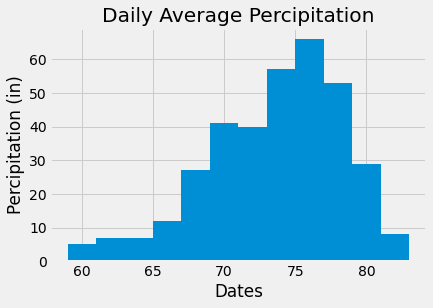

In [226]:
plt.hist(station_db['tobs'],bins=12)
plt.title('Daily Average Percipitation')
plt.xlabel('Dates')
plt.ylabel('Percipitation (in)')

# Close session

In [201]:
# Close Session
session.close()